In [ ]:
import time
from matplotlib import pyplot as plt
import numpy as np
from autograd import grad
from autograd import numpy as anp
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import laplace

In [ ]:
# we have already defined TV2 function above and now it needs to be applied only on theta
# cost function : C(theta)=|| H - (R^2 + O^2 + 2|R||O|cos(theta-theta_r))||^2 + alpha . TV(theta)
def TV_smoothness_penalty(phase):
    grad_x, grad_y = anp.gradient(phase)
    penalty = anp.sum(anp.abs(grad_x)**2 + anp.abs(grad_y)**2)
    return penalty

gradient_TV=grad(TV_smoothness_penalty)
def tv_phase_retrieval(H,O, R, mask, alpha=1e-3, iterations=50, step_size=1e-3):
     # --- Backtracking Parameters ---
    t = 1.0           # Initial step size to try
    beta_shrink = 0.5 # Factor to shrink t if the step is too large
    c_cond = 0.5      # Condition for sufficient decrease (Armijo condition)

    phi_estimate = (anp.random.randn(*R.shape) + 1j * anp.random.randn(*R.shape)) * 1e-5
    phi_r = anp.angle(R)

    # --- Nested Cost Function ---
    # This is needed to check if a step size 't' provides sufficient decrease.
    def cost_function(phi_est):
        # Data fidelity term
        pred_intensity = anp.abs(R)**2 + anp.abs(O)**2 + 2 * anp.abs(R) * anp.abs(O) * anp.cos(phi_est - phi_r)
        data_cost = anp.sum((H - pred_intensity)**2)

        # Regularization term
        reg_cost = TV_smoothness_penalty(phi_est)

        return data_cost + alpha * reg_cost

    for i in range(iterations):
        # --- 1. Calculate the gradient at the current position ---
        cost_current = cost_function(phi_estimate)

        pred_intensity = anp.abs(R)**2 + anp.abs(O)**2 + 2 * anp.abs(R) * anp.abs(O) * anp.cos(phi_estimate - phi_r)
        error_term = H - pred_intensity
        grad_data = 2* anp.abs(R) * anp.abs(O)*error_term * anp.sin(phi_estimate - phi_r) # Simplified gradient for data term
        grad_reg = (gradient_TV(phi_estimate))
        total_gradient = grad_data + alpha * grad_reg
        grad_norm_sq = anp.linalg.norm(total_gradient)**2

        # --- 2. Backtracking Line Search to find the best step size 't' ---
        t = 1e-1 # Reset step size for each iteration
        while cost_function(phi_estimate - t * total_gradient) > cost_current - c_cond * t * grad_norm_sq:
            t = beta_shrink * t

        # --- 3. Perform the update with the accepted step size 't' ---
        phi_estimate = (phi_estimate - t * total_gradient)

    return phi_estimate


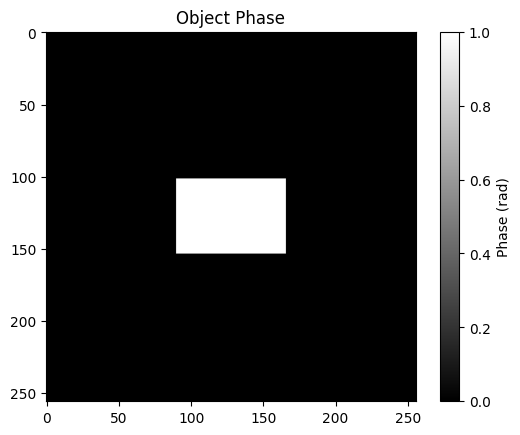

In [ ]:
def generate_rectangle(size, width=0.6, height=0.4, phase=1):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(x, y)

    mask = (np.abs(xx) < width/2) & (np.abs(yy) < height/2)
    obj_amp = 1
    obj_phase = phase * mask

    o_true = obj_amp * np.exp(1j * obj_phase)

    tilt_x = 20 * np.pi
    r_beam = np.exp(1j * tilt_x * xx)

    return o_true,obj_phase,mask
o,obj_phase,mask=generate_rectangle(256)
plt.imshow(np.angle(o),cmap='grey')
plt.title(f'Object Phase')
plt.colorbar(label='Phase (rad)')
plt.show()

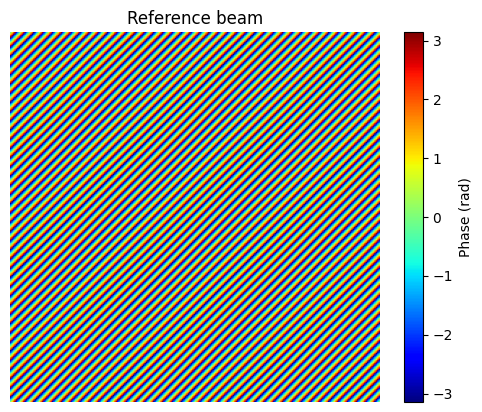

In [ ]:
x = np.linspace(-1, 1, 256)
y = np.linspace(-1, 1, 256)
X, Y = np.meshgrid(x, y)
R_beam = 1.0 * anp.exp(1j * (2 * anp.pi * 20 * X+2 * anp.pi * 20 * Y))
phi_r = anp.angle(R_beam)
plt.imshow(phi_r, cmap='jet', vmin=-anp.pi, vmax=anp.pi)
plt.title(f'Reference beam')
plt.colorbar(label='Phase (rad)')
plt.axis('off')
plt.show()

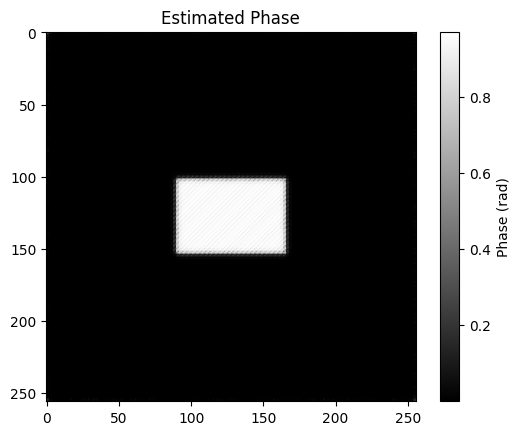

In [ ]:
# applying the phase-only optimisation to the rectangular object
H = np.abs(o + R_beam)**2
phi_estimated=tv_phase_retrieval(H,o, R_beam, mask, alpha=1, iterations=100, step_size=1e-3)


plt.imshow(np.abs(phi_estimated), cmap='grey')
plt.title(f'Estimated Phase')
plt.colorbar(label='Phase (rad)')
plt.show()

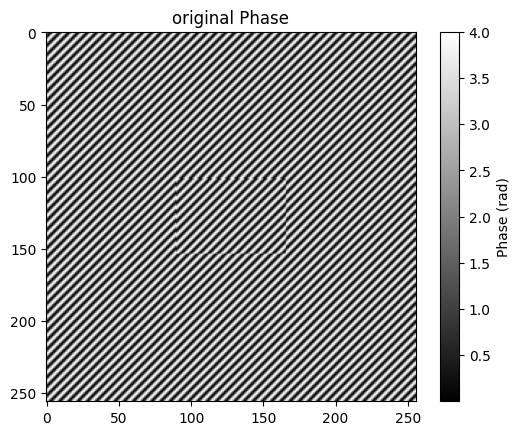

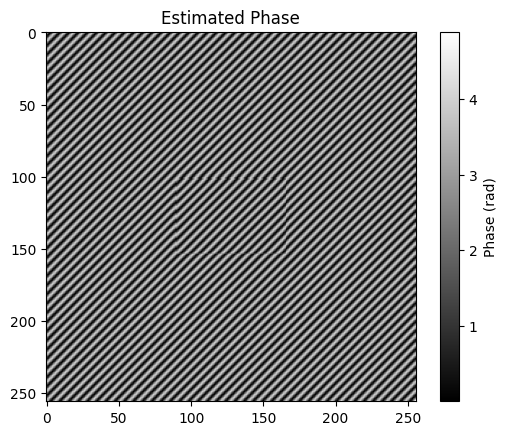

In [ ]:
H1 = np.abs(1*np.exp(1j * phi_estimated) + R_beam)**2
H = np.abs(o + R_beam)**2
# phi_estimated2=tv_phase_retrieval(H,1*np.exp(1j * phi_estimated), R_beam, mask, alpha=1e-3, iterations=100, step_size=1e-3)

plt.imshow(np.abs(H), cmap='grey')
plt.title(f'original Phase')
plt.colorbar(label='Phase (rad)')
plt.show()

plt.imshow(np.abs(H1), cmap='grey')
plt.title(f'Estimated Phase')
plt.colorbar(label='Phase (rad)')
plt.show()

In [ ]:
print(TV_smoothness_penalty(o))
print(TV_smoothness_penalty(1*np.exp(1j * phi_estimated) ))

117.6826096977562
66.12196046788777


In [ ]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

###########################################
# STEP 1 – Load and normalize hologram
###########################################
H_raw = imageio.imread("1dhm.png")
H_gray = np.mean(H_raw, axis=2).astype(float)
H = (H_gray - H_gray.min()) / (H_gray.max() - H_gray.min())

###########################################
# STEP 2 – FFT + detect +1 order
###########################################
F = np.fft.fftshift(np.fft.fft2(H))
mag = np.abs(F)

cy, cx = np.array(H.shape)//2

# ignore DC in center
mask_dc = (np.indices(mag.shape)[0]-cy)**2 + (np.indices(mag.shape)[1]-cx)**2 < 20**2
mag2 = mag.copy()
mag2[mask_dc] = 0

# peak index
peak_idx = np.unravel_index(np.argmax(mag2), mag2.shape)
py, px = peak_idx

###########################################
# STEP 3 – Crop +1 order → object wave O
###########################################
r_obj = 25  # radius of crop (important!)
Y, X = np.ogrid[:H.shape[0], :H.shape[1]]
mask_obj = (X-px)**2 + (Y-py)**2 < r_obj**2

F_obj = np.zeros_like(F)
F_obj[mask_obj] = F[mask_obj]

# shift peak to center
F_obj_center = np.roll(np.roll(F_obj, cy-py, axis=0), cx-px, axis=1)

O = np.fft.ifft2(np.fft.ifftshift(F_obj_center))

###########################################
# STEP 4 – Construct REFERENCE wave R
###########################################
r_ref = 3   # small mask for reference
mask_ref = (X-px)**2 + (Y-py)**2 < r_ref**2

F_ref = np.zeros_like(F)
F_ref[mask_ref] = F[mask_ref]

F_ref_center = np.roll(np.roll(F_ref, cy-py, axis=0), cx-px, axis=1)
R_raw = np.fft.ifft2(np.fft.ifftshift(F_ref_center))

# Scale reference power
I_o = np.sum(np.abs(O)**2)
I_r_raw = np.sum(np.abs(R_raw)**2)

alpha = np.sqrt(I_o / (I_r_raw + 1e-12))  # equal-energy
R = alpha * R_raw

###########################################
# Phase of reference needed for cost fn
###########################################
phi_r = np.angle(R)


In [ ]:
phi_est = tv_phase_retrieval(H, O, R, mask=None, alpha=1e-3,
                             iterations=50, step_size=1e-3)

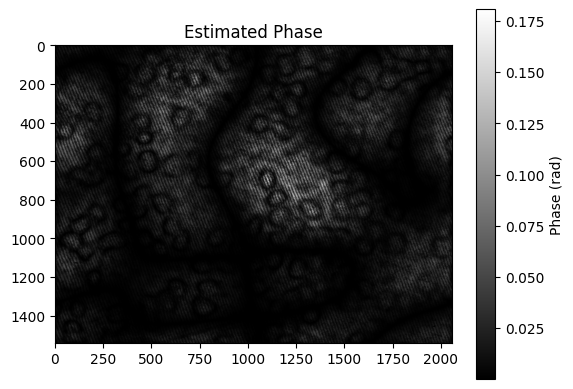

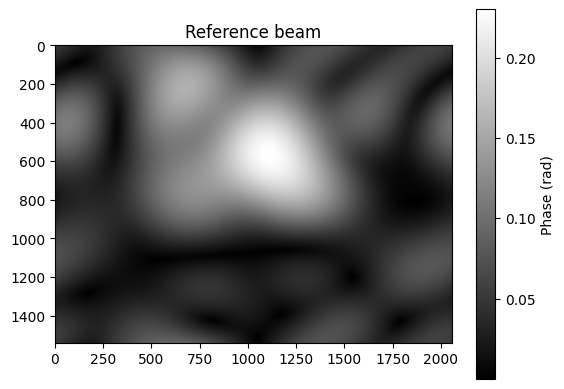

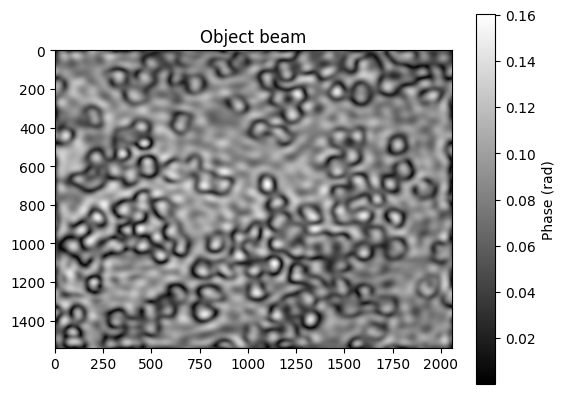

In [ ]:
plt.imshow(np.abs(phi_est), cmap='grey')
plt.title(f'Estimated Phase')
plt.colorbar(label='Phase (rad)')
plt.show()
plt.imshow(np.abs(R), cmap='grey')
plt.title(f'Reference beam')
plt.colorbar(label='Phase (rad)')
plt.show()
plt.imshow(np.abs(O), cmap='grey')
plt.title(f'Object beam')
plt.colorbar(label='Phase (rad)')
plt.show()

In [ ]:
# simulates hologram I_sim = |O + R|^2 and runs gradient-descent phase retrieval on theta
# with a smoothness (TV^2) penalty. Produces plots with colorbars at each key step,
# shows RMSE vs iterations, and saves summary images.
import imageio.v2 as imageio
import numpy as np, matplotlib.pyplot as plt, os
from scipy import ndimage
from skimage import color, exposure

def fft2(x): return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x)))
def ifft2(X): return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(X)))

def find_offaxis_peak(I, exclude_radius=15):
    F = fft2(I)
    mag = np.abs(F)
    cy, cx = np.array(mag.shape)//2
    y, x = np.ogrid[:mag.shape[0], :mag.shape[1]]
    mask_center = (x-cx)**2 + (y-cy)**2 > exclude_radius**2
    mag_masked = mag * mask_center
    idx = np.unravel_index(np.argmax(mag_masked), mag_masked.shape)
    return idx, F, mag

def make_circular_mask(shape, center, r):
    Y, X = np.ogrid[:shape[0], :shape[1]]
    cx, cy = center[1], center[0]
    mask = ((X-cx)**2 + (Y-cy)**2) <= r*r
    return mask

def laplacian(u):
    return ndimage.laplace(u, mode='reflect')

def circular_rmse(phi_ref, phi_hat):
    d = np.angle(np.exp(1j*(phi_ref - phi_hat)))
    return np.sqrt(np.mean(d.ravel()**2))

# Load image
img_path = "37a.png"
I_raw = imageio.imread(img_path)
if I_raw.ndim==3:
    I_gray = np.mean(I_raw, axis=2).astype(np.float32)
else:
    I_gray = I_raw.astype(np.float32)
I_norm = (I_gray - I_gray.min())/(I_gray.max()-I_gray.min())

# Crop center to 512x512 for stable FFT handling
h,w = I_norm.shape
size = 512
cy, cx = h//2, w//2
starty = max(0, cy-size//2); startx = max(0, cx-size//2)
I = I_norm[starty:starty+size, startx:startx+size]

# Reconstruct complex field O from +1 order of the raw hologram
peak_idx, F_img, mag_img = find_offaxis_peak(I, exclude_radius=20)
mask_radius_obj = 25
mask_obj = make_circular_mask(F_img.shape, peak_idx, mask_radius_obj)
F_obj = np.zeros_like(F_img); F_obj[mask_obj] = F_img[mask_obj]
# shift peak to center
cy2, cx2 = np.array(F_img.shape)//2
shift_y = cy2 - peak_idx[0]; shift_x = cx2 - peak_idx[1]
F_obj_centered = np.roll(np.roll(F_obj, shift_y, axis=0), shift_x, axis=1)
O = ifft2(F_obj_centered)
O = O / np.sqrt(np.mean(np.abs(O)**2))

# Ground-truth phase for comparisons is the phase from this FFT-reconstructed O
phase_gt = np.angle(O)
amp_gt = np.abs(O)

# Construct synthetic reference R from a small mask around same FT peak of E_rec
F_E = fft2(O)
mag_FE = np.abs(F_E)
# find dominant peak away from center in F_E
yidx, xidx = np.unravel_index(np.argmax(mag_FE * (((np.indices(mag_FE.shape)[0]-mag_FE.shape[0]//2)**2 + (np.indices(mag_FE.shape)[1]-mag_FE.shape[1]//2)**2) > 4)), mag_FE.shape)
r_ref = 3
mask_ref = make_circular_mask(F_E.shape, (yidx,xidx), r_ref)
F_ref = np.zeros_like(F_E); F_ref[mask_ref] = F_E[mask_ref]
# center it
shift_y2 = cy2 - yidx; shift_x2 = cx2 - xidx
F_ref_centered = np.roll(np.roll(F_ref, shift_y2, axis=0), shift_x2, axis=1)
R_raw = ifft2(F_ref_centered)
# scale reference to equal energy
I_o = np.sum(np.abs(O)**2)
I_r_raw = np.sum(np.abs(R_raw)**2)
alpha_eq = np.sqrt(I_o/(I_r_raw+1e-12))
# R = alpha_eq * R_raw
R = R_raw
phi_r = np.angle(R)
amp_R = np.abs(R)

# Simulate hologram using O and R (this is the measured H for optimization)
H_sim = np.abs(O + R)**2

# Prepare mask of object region (simple amplitude-based threshold of amp_gt)
amp_smooth = ndimage.gaussian_filter(amp_gt, sigma=3)
mask_obj_region = amp_smooth > (0.5*np.percentile(amp_smooth, 90))
# ensure mask is boolean
mask_obj_region = mask_obj_region.astype(bool)

# Phase retrieval optimization: optimize theta only (phase), amplitude fixed
# Parameters
alpha = 1   # TV weight (adjustable)
iters = 100
step = 5e-4

# Initialize theta (small random)
theta = np.angle(O) + 0.1*np.random.randn(*O.shape)  # initialize near gt but with noise

# Storage for snapshots
snapshots = {}
rmse_list = []

for it in range(iters):
    pred = (amp_R**2 + amp_gt**2 + 2*amp_R*amp_gt*np.cos(theta - phi_r))
    error = H_sim - pred
    # gradient of data term (following user's simplified formula)
    grad_data = 2 * amp_R * amp_gt * error * np.sin(theta - phi_r)
    # gradient of TV_smoothness = derivative of sum(|grad|^2) = -2*laplacian(theta)
    grad_reg = -2 * laplacian(theta)
    total_grad = grad_data + alpha * grad_reg
    theta = theta + step * total_grad  # ascend because grad_data sign chosen so this reduces cost
    # compute rmse with ground truth
    rmse = circular_rmse(phase_gt, theta)
    rmse_list.append(rmse)
    # save snapshots every 20 iterations and first and last
    if it%20==0 or it==iters-1:
        snapshots[it] = theta.copy()



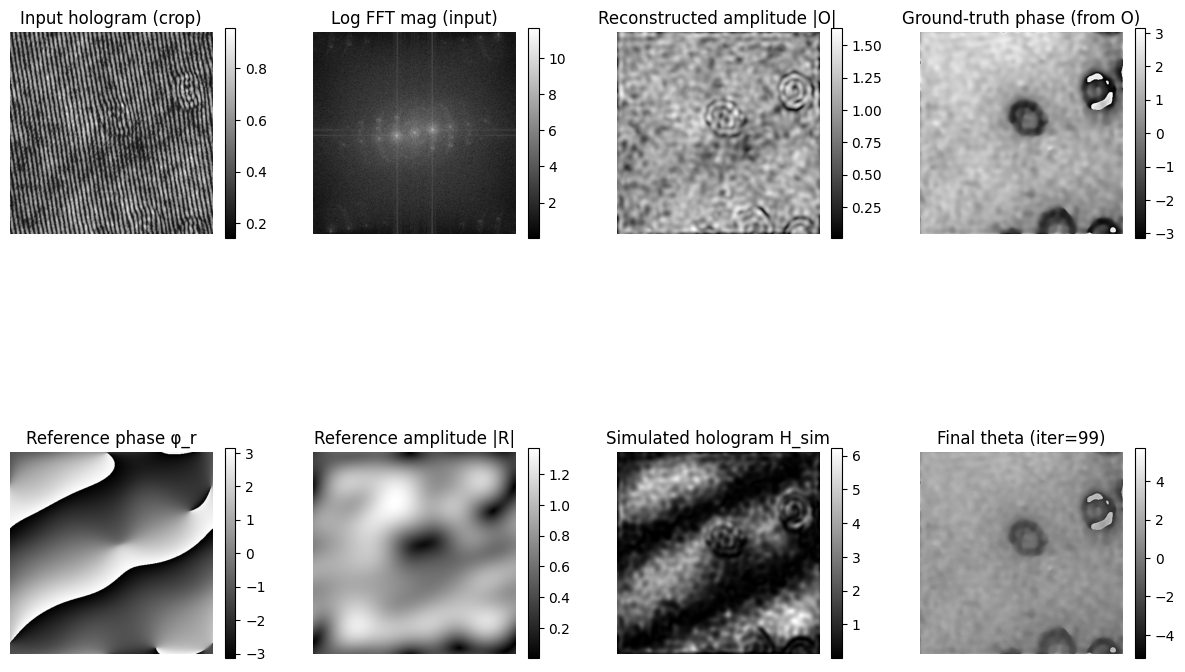

In [ ]:
# Plotting results with colorbars at each key step
plt.figure(figsize=(15,10))

plt.subplot(2,4,1)
plt.imshow(I, cmap='gray'); plt.title("Input hologram (crop)"); plt.axis('off')
plt.colorbar(shrink=0.6)

plt.subplot(2,4,2)
plt.imshow(np.log1p(mag_img), cmap='gray'); plt.title("Log FFT mag (input)"); plt.axis('off')
plt.colorbar(shrink=0.6)

plt.subplot(2,4,3)
plt.imshow(amp_gt, cmap='gray'); plt.title("Reconstructed amplitude |O|"); plt.axis('off')
plt.colorbar(shrink=0.6)

plt.subplot(2,4,4)
plt.imshow(phase_gt, cmap='gray'); plt.title("Ground-truth phase (from O)"); plt.axis('off')
plt.colorbar(shrink=0.6)

plt.subplot(2,4,5)
plt.imshow(np.angle(R), cmap='gray'); plt.title("Reference phase φ_r"); plt.axis('off')
plt.colorbar(shrink=0.6)

plt.subplot(2,4,6)
plt.imshow(np.abs(R), cmap='gray'); plt.title("Reference amplitude |R|"); plt.axis('off')
plt.colorbar(shrink=0.6)

plt.subplot(2,4,7)
plt.imshow(H_sim, cmap='gray'); plt.title("Simulated hologram H_sim"); plt.axis('off')
plt.colorbar(shrink=0.6)

# plt.subplot(3,3,8)
# plt.plot(rmse_list); plt.title("Circular RMSE vs iterations"); plt.xlabel("Iteration"); plt.ylabel("RMSE (rad)")

# show final estimated phase
plt.subplot(2,4,8)
plt.imshow(theta, cmap='gray'); plt.title(f"Final theta (iter={iters-1})"); plt.axis('off')
plt.colorbar(shrink=0.6)





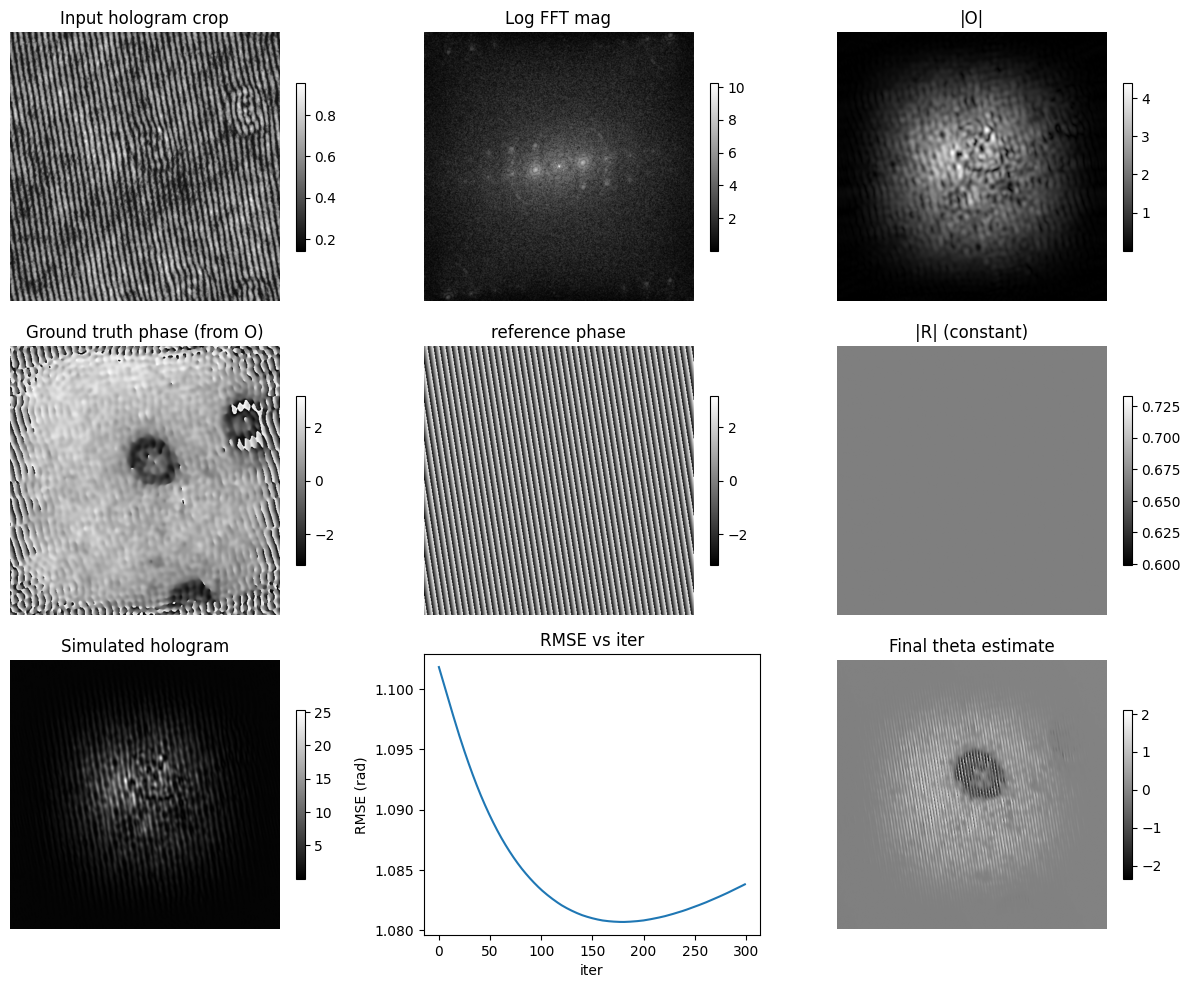

In [ ]:
# Corrected phase retrieval pipeline with clean plane-wave reference and proper gradient descent.
import imageio.v2 as imageio, numpy as np, matplotlib.pyplot as plt, os
from scipy import ndimage
from skimage import filters
from math import pi

# helpers
def fft2(x): return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x)))
def ifft2(X): return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(X)))
def circular_rmse(phi_ref, phi_hat):
    d = np.angle(np.exp(1j*(phi_ref - phi_hat)))
    return np.sqrt(np.mean(d.ravel()**2))
def make_circular_mask(shape, center, r):
    Y, X = np.ogrid[:shape[0], :shape[1]]
    cx, cy = center[1], center[0]
    mask = ((X-cx)**2 + (Y-cy)**2) <= r*r
    return mask
def fit_plane(phi):
    # fit plane a*x + b*y + c to phi and return fitted plane
    ny, nx = phi.shape
    Y, X = np.mgrid[0:ny, 0:nx]
    A = np.column_stack([X.ravel(), Y.ravel(), np.ones(phi.size)])
    coeff, *_ = np.linalg.lstsq(A, phi.ravel(), rcond=None)
    plane = (coeff[0]*X + coeff[1]*Y + coeff[2]).reshape(phi.shape)
    return plane, coeff

# Load hologram
img_path = "37a.png"
I_raw = imageio.imread(img_path)
if I_raw.ndim==3:
    I_gray = np.mean(I_raw, axis=2).astype(np.float32)
else:
    I_gray = I_raw.astype(np.float32)
I = (I_gray - I_gray.min())/(I_gray.max()-I_gray.min())

# crop center 512
h,w = I.shape; N=512
cy, cx = h//2, w//2
starty = max(0, cy-N//2); startx = max(0, cx-N//2)
I_crop = I[starty:starty+N, startx:startx+N]

# optional apodization to reduce leakage (tukey)
def tukey2d(shape, alpha=0.2):
    ny, nx = shape
    wx = np.hanning(nx)
    wy = np.hanning(ny)
    return np.outer(wy, wx)
window = tukey2d(I_crop.shape, alpha=0.3)
I_win = I_crop * window

# find off-axis peak
F = fft2(I_win); mag = np.abs(F)
cy2, cx2 = np.array(mag.shape)//2
# mask out small center
yy, xx = np.indices(mag.shape)
mask_center = ((xx-cx2)**2 + (yy-cy2)**2) > (18**2)
mag_masked = mag * mask_center
peak_idx = np.unravel_index(np.argmax(mag_masked), mag_masked.shape)
py, px = peak_idx

# crop +1 order to form O
r_obj = 40
mask_obj = make_circular_mask(F.shape, peak_idx, r_obj)
F_obj = np.zeros_like(F); F_obj[mask_obj] = F[mask_obj]
# shift to center
shifty = cy2 - py; shiftx = cx2 - px
F_obj_c = np.roll(np.roll(F_obj, shifty, axis=0), shiftx, axis=1)
O = ifft2(F_obj_c)
# normalize amplitude scale
O = O / np.sqrt(np.mean(np.abs(O)**2))
amp_O = np.abs(O); phi_gt = np.angle(O)

# construct clean plane-wave reference using peak location
# compute spatial frequencies (u0,v0) in cycles per pixel
u0 = (px - cx2) / F.shape[1]
v0 = (py - cy2) / F.shape[0]
Y, X = np.mgrid[0:N, 0:N]
phase_r_clean = 2*pi*(u0*X + v0*Y)  # pure plane wave
R_amp = np.mean(amp_O)  # choose amplitude similar to object mean
R = R_amp * np.exp(1j*phase_r_clean)   # clean plane wave
phi_r = np.angle(R); amp_R = np.abs(R)

# simulate hologram H_sim
H_sim = np.abs(O + R)**2
# initial theta guess: angle of O (or zeros)
theta = np.angle(O) * 0.0  # start from zero to test convergence

# optimization parameters (use descent)
alpha = 1e-2   # TV weight
iters = 300
eta = 5e-4     # step size
rmse_list = []
snapshots = {}

# compute gradient operators via finite differences
def grad_x(u): return np.roll(u, -1, axis=1) - u
def grad_y(u): return np.roll(u, -1, axis=0) - u
def div(px, py):
    return (px - np.roll(px, 1, axis=1)) + (py - np.roll(py, 1, axis=0))

for it in range(iters):
    pred = amp_R**2 + amp_O**2 + 2*amp_R*amp_O*np.cos(theta - phi_r)
    resid = pred - H_sim  # pred - measured (we want to minimize (H - pred)^2)
    # d(pred)/d theta = -2*amp_R*amp_O*sin(theta-phi_r)
    dpred_dtheta = -2*amp_R*amp_O*np.sin(theta - phi_r)
    grad_data = 2 * resid * dpred_dtheta  # derivative of sum (H - pred)^2 = 2*(H-pred)*(-dpred)
    # TV regularizer grad: grad of sum(|grad|^2) = -2 * laplacian(theta)
    # compute laplacian via divergence of gradient
    gx = grad_x(theta); gy = grad_y(theta)
    lap = (np.roll(theta, -1, axis=1) + np.roll(theta, 1, axis=1) + np.roll(theta, -1, axis=0) + np.roll(theta, 1, axis=0) - 4*theta)
    grad_reg = -2 * lap
    total_grad = grad_data + alpha * grad_reg
    # gradient descent update
    theta = theta - eta * total_grad
    # remove global plane fit each few iterations for stability
    if it % 20 == 0:
        plane, coeff = fit_plane(theta)
        theta = theta - plane  # remove fitted plane (keeps solution zero-mean)
    # compute rmse against ground truth after removing best-fit plane from both
    plane_gt, _ = fit_plane(phi_gt)
    plane_theta, _ = fit_plane(theta)
    rmse = circular_rmse(phi_gt - plane_gt, theta - plane_theta)
    rmse_list.append(rmse)
    if it % 50 == 0 or it == iters-1:
        snapshots[it] = theta.copy()

# Plot results and save
plt.figure(figsize=(12,10))
plt.subplot(3,3,1); plt.imshow(I_crop, cmap='gray'); plt.title("Input hologram crop"); plt.axis('off'); plt.colorbar(shrink=0.6)
plt.subplot(3,3,2); plt.imshow(np.log1p(np.abs(fft2(I_win))), cmap='gray'); plt.title("Log FFT mag"); plt.axis('off'); plt.colorbar(shrink=0.6)
plt.subplot(3,3,3); plt.imshow(amp_O, cmap='gray'); plt.title("|O|"); plt.axis('off'); plt.colorbar(shrink=0.6)
plt.subplot(3,3,4); plt.imshow(phi_gt, cmap='gray'); plt.title("Ground truth phase (from O)"); plt.axis('off'); plt.colorbar(shrink=0.6)
plt.subplot(3,3,5); plt.imshow(phi_r, cmap='gray'); plt.title("reference phase"); plt.axis('off'); plt.colorbar(shrink=0.6)
plt.subplot(3,3,6); plt.imshow(amp_R, cmap='gray'); plt.title("|R| (constant)"); plt.axis('off'); plt.colorbar(shrink=0.6)
plt.subplot(3,3,7); plt.imshow(H_sim, cmap='gray'); plt.title("Simulated hologram"); plt.axis('off'); plt.colorbar(shrink=0.6)
plt.subplot(3,3,8); plt.plot(rmse_list); plt.title("RMSE vs iter"); plt.xlabel("iter"); plt.ylabel("RMSE (rad)")
plt.subplot(3,3,9); plt.imshow(theta, cmap='gray'); plt.title("Final theta estimate"); plt.axis('off'); plt.colorbar(shrink=0.6)
plt.tight_layout()
